In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import control as ctl

# EXTRAINDO OS DADOS

In [2]:
df = pd.read_csv('../DataBase.csv')
df = df[['time', 'theta', 'distance']]
df

,time,theta,distance
0,0.00,100,3.69
1,0.00,100,3.67
2,0.01,100,3.69
3,0.01,100,3.69
4,0.01,100,3.67
...,...,...,...
269,4.94,100,19.72
270,4.96,100,19.72
271,4.98,100,19.72
272,5.00,100,19.74


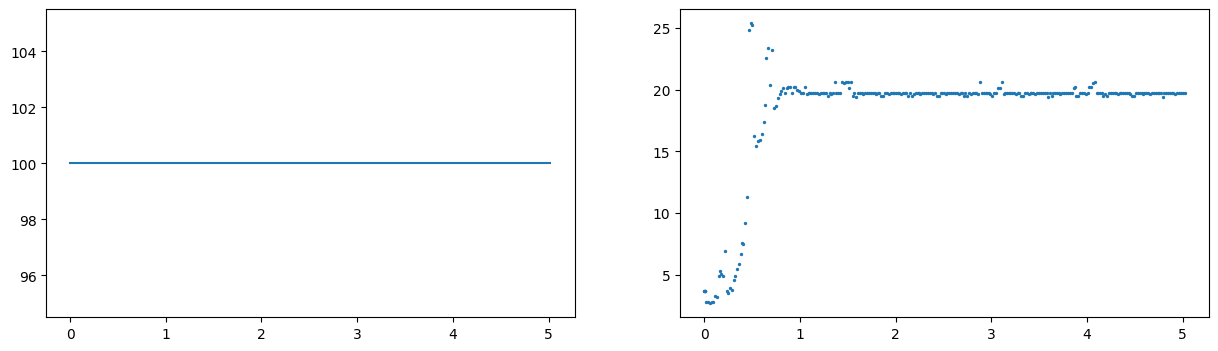

In [3]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(df['time'], df['theta'])

plt.subplot(1, 2, 2)
plt.scatter(df['time'], df['distance'], s=2)

# FILTRANDO OS DADOS

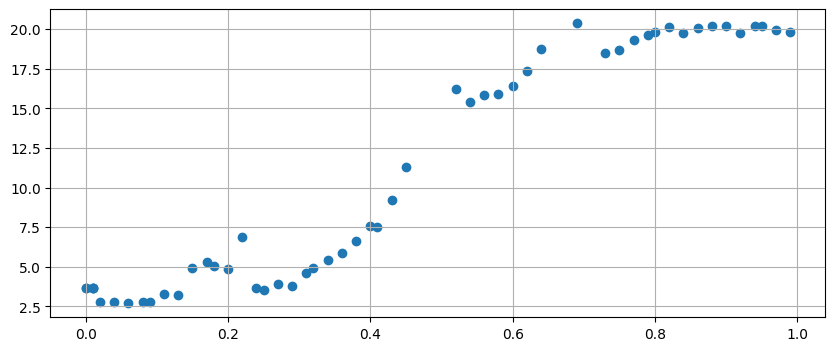

In [4]:
df = df.loc[df['distance'] < 22]
df = df.loc[df['distance'] > 2.5]
df = df.loc[df['time'] < 1]

plt.figure(figsize=(10, 4))
plt.scatter(df['time'], df['distance'])
plt.grid()
plt.show()

In [5]:
positions = np.arange(df['time'].min(), df['time'].max(), 0.1)
positions

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

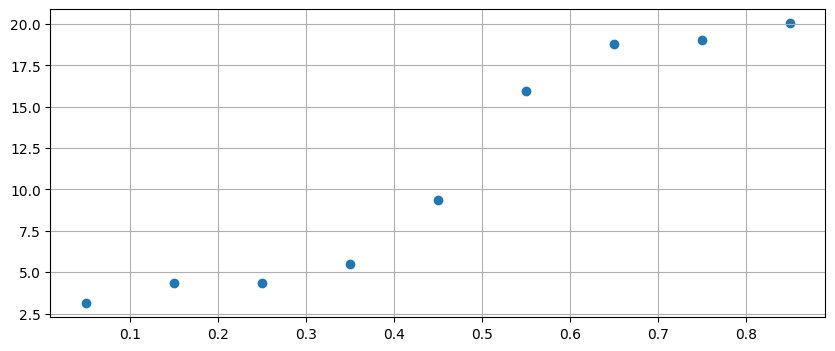

In [6]:
time     = df['time'].to_numpy()
response = df['distance'].to_numpy()

tData = []
yData = []

for i in range(len(positions) - 1):
    position = positions[i]
    next_position = positions[i + 1]

    target = response[(time > position) & (time < next_position)]
    
    if len(target) == 0:
        continue

    t = (next_position + position)/2
    y = target.mean()

    tData.append(t)
    yData.append(y)

plt.figure(figsize=(10, 4))
plt.scatter(tData, yData)
plt.grid()
plt.show()

# ESBOÇANDO O GRÁFICO NO DOMÍNIO DO TEMPO
O gráfico expressa a função de transferência no domínio do tempo $Y(s) = L^{-1}\{y(t)\}$

### ADAPTANDO OS DADOS PARA UMA FUNÇÃO POR CURVE FIT

In [7]:
# Função para uso com curve_fit (NumPy)
def f(t, a, b, c):
    return a*np.exp(b*t) + c

# Função para representação simbólica (SymPy)
def f_sp(t, a, b, c):
    return a*sp.exp(b*t) + c

def getFunction(xDados, yDados):
    coeficientes = curve_fit(f, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

def roundSympyFunction(expr, num_digits=8):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

In [8]:
coefs = getFunction(tData, yData)  
f_sp = roundSympyFunction(f_sp(sp.var('t'), *coefs))
f_sp

40.62575236*exp(0.49401493*t) - 39.98333455

### COMPARANDO A FUNÇÃO OBTIDA
Vemos que realmente bate com a função que encontramos apenas pelo gráfico de pontos

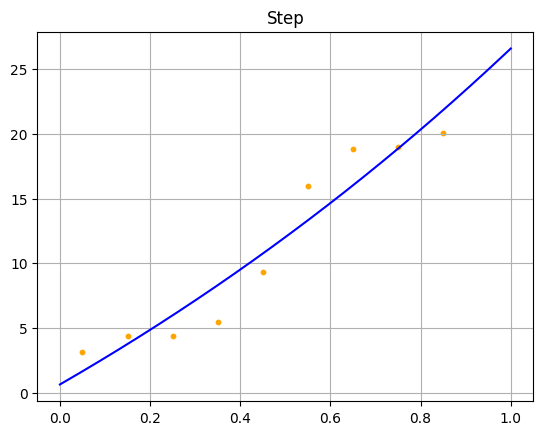

In [9]:
time     = np.linspace(0, 1, 1000)
response = f(time, *coefs)

plt.scatter(tData, yData, color='orange', s=10)
plt.plot(time, response, color='blue')
plt.title('Step')
plt.grid()
plt.show()

In [10]:
def transformadaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.laplace_transform(function, t, s)[0].expand().simplify()

def transformadaInversaLaplace(function):   
    t, s = sp.symbols('t s')
    return sp.inverse_laplace_transform(function, s, t).expand().simplify()

Y = transformadaLaplace(f_sp)
Y = roundSympyFunction(Y)
Y

(0.64241781*s + 19.75236422)/(s*(s - 0.49401493))

In [11]:
r = 100
R = transformadaLaplace(r)
R

100/s

- A função de transferência é a razão da saída pela entrada, ou seja, $G(s) = \frac{Y(s)}{R(s)}$ 

In [12]:
G = (Y/R).factor()
print(G)

0.1975236421*(0.03252359073*s + 1.0)/(1.0*s - 0.49401493)


In [13]:
s = ctl.TransferFunction.s

G = eval(str(G))
G

TransferFunction(array([0.00642418, 0.19752364]), array([ 1.        , -0.49401493]))

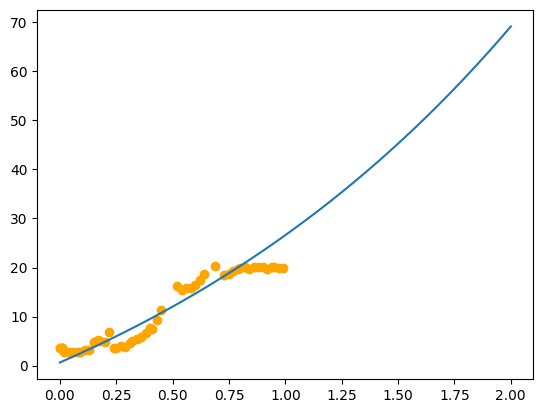

In [14]:
T = np.linspace(0, 2, 1000)
U = r * np.ones(1000)
time, response = ctl.forced_response(G, T=T, U=U)

plt.plot(time, response)
plt.scatter(df['time'], df['distance'], color='orange')